# 변경이 필요한 부분

- 인코더를 없애고
- 디코더 내의 인코더-디코더-어텐션 부분을 없앤다
- 인코더의 입력으로 쓰이던 질문들을 디코더의 입력으로 넣는다

In [1]:
!pip install sentencepiece

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import sentencepiece as spm

import math
import os
import re
import urllib.request
import zipfile
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import pandas as pd

df = pd.read_csv("./data/ChatbotData.csv")

In [4]:
df.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [5]:
def preprocess_sentence(sentence):
  # 입력받은 sentence를 소문자로 변경하고 문장 앞 뒤의 공백을 제거
  sentence = sentence.lower().strip()

  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # 예를 들어서 "12시가 땡!" => "12시가 땡 !"와 같이
  # 땡과 느낌표 사이에 거리를 만듭니다.
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)

  # 연속된 공백을 하나의 공백으로 축소
  sentence = re.sub(r'[" "]+', " ", sentence)

  #한글, 영어, 숫자, 구두점만 남기고 나머지 제고
  sentence = re.sub(r"[^가-힣a-zA-Z0-9?.!,]+", " ", sentence)
  sentence = sentence.strip() # 앞 뒤 공백 다시 제거
  return sentence
print("슝=3")

슝=3


In [6]:
print(preprocess_sentence("12시 땡!"))   # 결과: "12시 땡 !"
print(preprocess_sentence("PPL 심하네??")) # 결과: "ppl 심하네 ??"

12시 땡 !
ppl 심하네 ? ?


In [7]:
from pathlib import Path
csv_path = Path.home() / "work/transformer_chatbot/data/ChatbotData.csv"

# Q/A 각각 전처리 적용
# astype(str)은 결측값이나 숫자가 있어도 str로 변환
df['Q'] = df['Q'].astype(str).apply(preprocess_sentence)
df['A'] = df['A'].astype(str).apply(preprocess_sentence)

In [8]:
df.head(10)   # 앞 10행 확인해서 잘 적용됐는 지 확인

,Q,A,label
0,12시 땡 !,하루가 또 가네요 .,0
1,1지망 학교 떨어졌어,위로해 드립니다 .,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠 .,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠 .,0
4,ppl 심하네,눈살이 찌푸려지죠 .,0
5,sd카드 망가졌어,다시 새로 사는 게 마음 편해요 .,0
6,sd카드 안돼,다시 새로 사는 게 마음 편해요 .,0
7,sns 맞팔 왜 안하지,잘 모르고 있을 수도 있어요 .,0
8,sns 시간낭비인 거 아는데 매일 하는 중,시간을 정하고 해보세요 .,0
9,sns 시간낭비인데 자꾸 보게됨,시간을 정하고 해보세요 .,0


In [9]:
print("빈 Q 개수:", (df['Q'].str.len() == 0).sum())
print("빈 A 개수:", (df['A'].str.len() == 0).sum())

빈 Q 개수: 0
빈 A 개수: 0


In [10]:
# 모델 학습용 pairs 생성
pairs = list(zip(df['Q'], df['A']))
print(pairs[:5])

[('12시 땡 !', '하루가 또 가네요 .'), ('1지망 학교 떨어졌어', '위로해 드립니다 .'), ('3박4일 놀러가고 싶다', '여행은 언제나 좋죠 .'), ('3박4일 정도 놀러가고 싶다', '여행은 언제나 좋죠 .'), ('ppl 심하네', '눈살이 찌푸려지죠 .')]


In [11]:
# pair를 txt 파일로 저장
corpus_file = "clean_corpus.txt"
with open(corpus_file, 'w', encoding='utf-8') as f:
    for q, a in pairs:
        f.write(q + "\n")
        f.write(a + "\n")

In [12]:
# sentencepiecetrainer 라이브러리를 이용해서 토크나이저 모델을 학습
spm.SentencePieceTrainer.Train(
    input=corpus_file, #방금 만든 txt
    model_prefix="spm_cornell", # 만들어지는 파일의 접두사 설정
    
    vocab_size=8000, #만들 서브워드 토큰 개수
    character_coverage=1.0, # 1.0이면 모든 문자 토큰화 (일본어나 중국어는 0.995로 희귀문자 희생시킴)
    
    model_type="bpe", # byte pair encoding 방식의 알고리즘 선택
    max_sentence_length=999999, # 학습할 때 문장 최대 길이

    # 특별 토큰 id 번호 고정
    bos_id=1,  # <s> (Beginning of Sentence) 설정
    eos_id=2,  # </s> (End of Sentence) 설정
    pad_id=0,  # Padding ID 설정
    unk_id=3   # Unknown Token ID 설정
)

# 실행 결과:
# -> spm_cornell.model, spm_cornell.vocab 생성

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: clean_corpus.txt
  input_format: 
  model_prefix: spm_cornell
  model_type: BPE
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 1
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 999999
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 3
  bos_id: 1
  eos_id: 2
  pad_id: 0
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy: 0
  differ

In [13]:
# 학습시킨 토크나이저 모델 테스트: 전처리부터 토큰화, 인코딩, 디코딩이 잘 동작하는 지?!
sp = spm.SentencePieceProcessor()
sp.Load("spm_cornell.model")

# 테스트할 문장 준비
sentence = "점심엔 뭘 먹을까?"

sentence = preprocess_sentence(sentence)
print("전처리 후의 문장:", sentence)

# 1. 토크나이징 (subword 단위로 분할)
tokens = sp.encode(sentence, out_type=str)
print("Tokenized:", tokens)

# 2. 인코딩 (서브워드를 정수 ID로 변환)
encoded = sp.encode(sentence, out_type=int)
print("Encoded:", encoded)

# 3. 디코딩 (정수 ID → 원본 문장 복원)
decoded = sp.decode(encoded)
print("Decoded:", decoded)

전처리 후의 문장: 점심엔 뭘 먹을까 ?
Tokenized: ['▁점심', '엔', '▁뭘', '▁먹을까', '▁?']
Encoded: [1825, 7356, 436, 2266, 11]
Decoded: 점심엔 뭘 먹을까 ?


In [14]:
from torch.utils.data import Dataset

class CornellDataset(Dataset):
    def __init__(self, pairs, sp, max_length= 40, add_special_tokens=True, use_sp_extra_opts=False):
        """
        pairs: [(q_text, a_text), ...]
        sp: sentencepiece processor
        max_length: 고정 길이 (BOS/EOS 포함 길이 기준)
        add_special_tokens: 수동으로 BOS/EOS 붙일지 여부
        use_sp_extra_opts: sp.SetEncodeExtraOptions("bos:eos") 를 이미 썼다면 True
        """
        super().__init__()
        self.sp = sp
        self.max_length = max_length
        self.data = []

        # 특수 토큰 ID 가져오기
        pad_id = sp.pad_id() if sp.pad_id() >= 0 else 0
        bos_id = sp.bos_id() if sp.bos_id() >= 0 else 1
        eos_id = sp.eos_id() if sp.eos_id() >= 0 else 2

        # Pair를 돌면서 텐서로 변환
        for q_text, a_text in pairs:
            # 1) 토크나이즈
            q_ids = sp.EncodeAsIds(q_text)
            a_ids = sp.EncodeAsIds(a_text)

            # 2) BOS/EOS 부착
            if use_sp_extra_opts:
                q_tokens = q_ids
                a_tokens = a_ids
            else:
                if add_special_tokens:
                    q_tokens = [bos_id] + q_ids + [eos_id]
                    a_tokens = [bos_id] + a_ids + [eos_id]
                else:
                    q_tokens = q_ids[:] # [:]는 복사를 의미. 원본 보존
                    a_tokens = a_ids[:]

            # 3) 길이 제한: 너무 길면 자른다.
            if len(q_tokens) > self.max_length:
                q_tokens = q_tokens[:self.max_length] 
            if len(a_tokens) > self.max_length:
                a_tokens = a_tokens[:self.max_length]

            # 4) 패딩: 부족한 길이는 PAD 토크으로 채워서 길이를 맞춤
            q_len = len(q_tokens)
            a_len = len(a_tokens)
            if q_len < self.max_length:
                q_tokens = q_tokens + [pad_id] * (self.max_length - q_len)
            if a_len < self.max_length:
                a_tokens = a_tokens + [pad_id] * (self.max_length - a_len)

            # 5) 디코더 입력 교사 강요용 시프트
            # dec_input: a[:-1], target: a[1:]
            dec_input = a_tokens[:-1] # 디코더는 dec_input 보고 target을 예측
            target = a_tokens[1:]

            # 6) 마스크 생성(Transformer 용)
            # enc_padding_mask: [B, 1, 1, L] 형태로 쓰는게 일반적이나,
            # 여기서는 [L]을 반환하고, 모델에서 차원 확장하는 방식으로 가볍게 둡니다.
            enc_padding_mask = [1 if tid != pad_id else 0 for tid in q_tokens]        # 1이면 유효토큰 keep, 0이면 차단하기 mask
            dec_padding_mask = [1 if tid != pad_id else 0 for tid in dec_input]        # 디코더 키패딩용

            # self.data에 딕셔너리로 저장
            self.data.append({
                "enc_input": q_tokens,
                "dec_input": dec_input,
                "target": target,
                "enc_padding_mask": enc_padding_mask,
                "dec_padding_mask": dec_padding_mask,
            })

    # 데이터셋 크기 반환
    def __len__(self):
        return len(self.data)

    # idx 번째 샘플을 텐서로 변환해서 반환
    def __getitem__(self, idx):
        s = self.data[idx]
        return (
            torch.tensor(s["enc_input"], dtype=torch.long),
            torch.tensor(s["dec_input"], dtype=torch.long),
            torch.tensor(s["target"], dtype=torch.long),
            torch.tensor(s["enc_padding_mask"], dtype=torch.long),
            torch.tensor(s["dec_padding_mask"], dtype=torch.long),
        )

In [15]:
# 길이 토큰 40으로 맞춰서 객체 생성
dataset = CornellDataset(pairs, sp, max_length=40)

In [16]:
#샘플 확인
pad_id = sp.pad_id() if sp.pad_id() >= 0 else 0
bos_id = sp.bos_id() if sp.bos_id() >= 0 else 1
eos_id = sp.eos_id() if sp.eos_id() >= 0 else 2

# ID 시퀀스를 사람이 읽을 수 있는 문자열로 복원
def trim_and_decode(sp, ids, pad_id=0, bos_id=1, eos_id=2):
    if hasattr(ids, "tolist"):
        ids = ids.tolist()
    ids = [i for i in ids if i != pad_id]           # PAD 제거
    if ids and ids[0] == bos_id: ids = ids[1:]      # BOS 제거
    if eos_id in ids: ids = ids[:ids.index(eos_id)] # EOS까지
    return sp.DecodeIds(ids) if hasattr(sp, "DecodeIds") else sp.decode_ids(ids)

for enc_in, dec_in, tgt, enc_mask, dec_mask in dataset:
    print("텐서 크기:", enc_in.size())
    print(enc_in)
    print("enc:", trim_and_decode(sp, enc_in, pad_id, bos_id, eos_id))
    print(dec_in)
    print("dec_in:", trim_and_decode(sp, dec_in, pad_id, bos_id, eos_id))
    print(tgt)
    print("tgt:", trim_and_decode(sp, tgt, pad_id, bos_id, eos_id))
    break

텐서 크기: torch.Size([40])
tensor([   1, 5550, 6817, 3199,  108,    2,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0])
enc: 12시 땡 !
tensor([   1, 4484,  214, 5918,    4,    2,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0])
dec_in: 하루가 또 가네요 .
tensor([4484,  214, 5918,    4,    2,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0])
tgt: 하루가 또 가네요 .


In [17]:
# 데이터 로더는 CornellDataset에서 샘플을 꺼내서 배치 단위의 텐서 묶음으로 만든다.
# 이 데이터로더를 학습 루프에 돌리면 된다.
dataloader = DataLoader(dataset,batch_size=32,shuffle=True)

In [18]:
for enc_in, dec_in, tgt, enc_mask, dec_mask in dataloader:
    print("enc_in     :", enc_in.shape)      # [32, 40]
    print("dec_in     :", dec_in.shape)      # [32, 39]
    print("tgt        :", tgt.shape)         # [32, 39]
    print("enc_mask   :", enc_mask.shape)    # [32, 40]
    print("dec_mask   :", dec_mask.shape)    # [32, 39]
    break

enc_in     : torch.Size([32, 40])
dec_in     : torch.Size([32, 39])
tgt        : torch.Size([32, 39])
enc_mask   : torch.Size([32, 40])
dec_mask   : torch.Size([32, 39])


In [19]:
class PositionalEncoding(nn.Module):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        self.position = position

        self.pos_encoding = self._build_pos_encoding(position, d_model)

    def _get_angles(self, position, i, d_model):
        return 1.0 / (10000.0 ** ((2.0 * (i // 2)) / d_model)) * position

    def _build_pos_encoding(self, position, d_model):
        pos = torch.arange(position, dtype=torch.float32).unsqueeze(1)
        i = torch.arange(d_model, dtype=torch.float32).unsqueeze(0)

        angle_rads = self._get_angles(pos, i, d_model)
        sines = torch.sin(angle_rads[:, 0::2])
        cosines = torch.cos(angle_rads[:, 1::2])

        pos_encoding = torch.zeros(position, d_model)
        pos_encoding[:, 0::2] = sines
        pos_encoding[:, 1::2] = cosines

        pos_encoding = pos_encoding.unsqueeze(0)  # shape: [1, position, d_model]
        return pos_encoding

    def forward(self, x):
        return x + self.pos_encoding[:, :x.size(1), :].to(x.device)

In [20]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        # d_model은 num_heads로 나누어떨어져야 함
        assert d_model % num_heads == 0

        self.depth = d_model // num_heads

        # 파이토치에서 Dense는 nn.Linear로 대응
        self.query_dense = nn.Linear(d_model, d_model)
        self.key_dense = nn.Linear(d_model, d_model)
        self.value_dense = nn.Linear(d_model, d_model)

        self.out_dense = nn.Linear(d_model, d_model)

    def split_heads(self, x, batch_size):
        """
        x: (batch_size, seq_len, d_model)
        => (batch_size, num_heads, seq_len, depth) 형태로 변환
        """
        x = x.view(batch_size, -1, self.num_heads, self.depth)
        x = x.permute(0, 2, 1, 3)  # (batch_size, num_heads, seq_len, depth)
        return x

    def forward(self, query, key, value, mask=None):
        """
        query, key, value: (batch_size, seq_len, d_model)
        mask: (batch_size, 1, seq_len, seq_len) 등으로 broadcast 가능하도록 구성
        """
        batch_size = query.size(0)

        # Q, K, V에 각각 Linear 적용
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # Head 분할
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션
        scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)

        # (batch_size, num_heads, seq_len, depth) -> (batch_size, seq_len, num_heads, depth)
        scaled_attention = scaled_attention.permute(0, 2, 1, 3).contiguous()

        # 다시 (batch_size, seq_len, d_model)로 합치기
        concat_attention = scaled_attention.view(batch_size, -1, self.d_model)

        # 최종 Dense
        output = self.out_dense(concat_attention)
        return output

In [21]:
def scaled_dot_product_attention(query, key, value, mask=None):

    # 1) Q와 K의 내적을 통해 score(유사도) 계산
    # key.transpose(-1, -2): (batch_size, heads, depth, seq_len)
    # matmul 결과 shape: (batch_size, heads, seq_len, seq_len)
    matmul_qk = torch.matmul(query, key.transpose(-1, -2))

    # 2) depth에 따라 정규화
    depth = key.size(-1)  # depth = d_model / heads
    logits = matmul_qk / math.sqrt(depth)

    # 3) 마스크가 주어졌다면 -1e9(아주 작은 값)를 더해 소프트맥스에서 제외시키도록 함
    if mask is not None:
        # 텐서플로우: logits += (mask * -1e9)
        # 파이토치 동일 적용
        logits = logits + (mask * -1e9)

    # 4) 소프트맥스 계산해 attention weights 생성
    attention_weights = F.softmax(logits, dim=-1)

    # 5) attention weights와 value의 내적
    output = torch.matmul(attention_weights, value)

    return output, attention_weights

# 인코더 삭제

# 디코더에서 인코더-디코더 어텐션 삭제
- 인코더가 사용되지 않으므로 인코더-디코더 어텐션 삭제
- 디코더 어텐션 출력을 피그포워드 레이어의 입력으로 사용 

In [22]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, ff_dim, dropout=0.1):
        super(DecoderLayer, self).__init__()

        # 첫 번째 서브 레이어 (디코더 내부 셀프 어텐션)
        self.self_mha = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model, eps=1e-6)

        # 두 번째 서브 레이어 (인코더-디코더 어텐션)
        # self.encdec_mha = MultiHeadAttention(d_model, num_heads)
        # self.norm2 = nn.LayerNorm(d_model, eps=1e-6)

        # 세 번째 서브 레이어 (피드포워드 네트워크)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_dim),  # Dense(units=ff_dim)
            nn.ReLU(),                   # activation='relu'
            nn.Linear(ff_dim, d_model)   # Dense(units=d_model)
        )
        self.norm3 = nn.LayerNorm(d_model, eps=1e-6)

        # 드롭아웃
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

    ## 인코더를 없애고 디코더의 출력이 피드포워드 레이어의 입력으로 가도록 수정
    
    # def forward(self, x, enc_outputs, look_ahead_mask=None, padding_mask=None):
    def forward(self, x, look_ahead_mask=None, padding_mask=None):
        # 1) 셀프 어텐션 (디코더 내부)
        self_attn_out = self.self_mha(x, x, x, mask=look_ahead_mask)
        self_attn_out = self.dropout1(self_attn_out)
        out1 = self.norm1(x + self_attn_out)  # 잔차 연결 + LayerNorm

        ## 이 부분은 인코더가 없어지므로 GPT1 모델에서는 사용하지 않음
        # 2) 인코더-디코더 어텐션
        # encdec_attn_out = self.encdec_mha(out1, enc_outputs, enc_outputs, mask=padding_mask)
        # encdec_attn_out = self.dropout2(encdec_attn_out)
        # out2 = self.norm2(out1 + encdec_attn_out)  # 잔차 연결 + LayerNorm

        # 3) 피드포워드 (Dense -> ReLU -> Dense)
        ffn_out = self.ffn(out1) ## 디코더의 출력이 입력이 됨
        ffn_out = self.dropout3(ffn_out)
        out3 = self.norm3(out1 + ffn_out)  # 잔차 연결 + LayerNorm

        return out3

In [23]:
class Decoder(nn.Module):
    def __init__(self,
                 vocab_size,
                 num_layers,
                 ff_dim,
                 d_model,
                 num_heads,
                 dropout=0.1):
        super(Decoder, self).__init__()
        self.d_model = d_model

        # (1) 임베딩 레이어
        self.embedding = nn.Embedding(vocab_size, d_model)

        # (2) 포지셔널 인코딩
        # 실제 학습 시에는 최대 시퀀스 길이에 맞추어 쓰기도 함
        self.pos_encoding = PositionalEncoding(position=vocab_size, d_model=d_model)

        self.dropout = nn.Dropout(dropout)

        # (3) DecoderLayer 쌓기
        self.dec_layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])

    # def forward(self, x, enc_outputs, look_ahead_mask=None, padding_mask=None):
    def forward(self, x, look_ahead_mask=None, padding_mask=None):
        # (1) 임베딩 + sqrt(d_model)로 스케일링
        x = self.embedding(x) * math.sqrt(self.d_model)

        # (2) 포지셔널 인코딩 + 드롭아웃
        x = self.pos_encoding(x)    # (batch_size, tgt_seq_len, d_model)
        x = self.dropout(x)

        # (3) num_layers만큼 쌓인 DecoderLayer 통과
        for layer in self.dec_layers:
            # x = layer(x, enc_outputs, look_ahead_mask, padding_mask)
            x = layer(x, look_ahead_mask, padding_mask)

        return x

In [24]:
def create_padding_mask(x):
    # x == 0 위치를 찾아 float형 1로 변환
    mask = (x == 0).float()
    # (batch_size, seq_len) -> (batch_size, 1, 1, seq_len)
    mask = mask.unsqueeze(1).unsqueeze(2)
    return mask

In [25]:

def create_look_ahead_mask(x):
    seq_len = x.size(1)

    # (seq_len, seq_len) 크기의 하삼각 행렬(tril) 생성 후 1에서 빼서
    # 상삼각이 1, 하삼각(자기 자신 포함)이 0이 되도록 설정
    # => 미래 토큰(자신 인덱스보다 큰 위치) 마스킹
    look_ahead_mask = 1 - torch.tril(torch.ones((seq_len, seq_len)))

    # 패딩 마스크 생성 (shape: (batch_size, 1, 1, seq_len))
    padding_mask = create_padding_mask(x)

    # look_ahead_mask: (seq_len, seq_len) -> (1, seq_len, seq_len)
    look_ahead_mask = look_ahead_mask.unsqueeze(0)
    # -> (1, seq_len, seq_len) -> (1, 1, seq_len, seq_len)
    look_ahead_mask = look_ahead_mask.unsqueeze(1)
    look_ahead_mask = look_ahead_mask.to(x.device)

    # look-ahead 마스크와 패딩 마스크를 합성 (둘 중 하나라도 1이면 마스킹)
    # 최종 shape은 브로드캐스팅으로 (batch_size, 1, seq_len, seq_len)
    combined_mask = torch.max(look_ahead_mask, padding_mask)
    return combined_mask

In [26]:
class Transformer(nn.Module):
    def __init__(self,
                 vocab_size,
                 num_layers,      # 인코더/디코더 층 수
                 units,           # feed-forward 네트워크의 중간 차원(ff_dim)
                 d_model,         # 임베딩 및 내부 표현 차원
                 num_heads,       # 멀티헤드 어텐션의 헤드 수
                 dropout=0.1):
        super(Transformer, self).__init__()

        # 인코더
        # self.encoder = Encoder(
        #     vocab_size=vocab_size,
        #     num_layers=num_layers,
        #     ff_dim=units,
        #     d_model=d_model,
        #     num_heads=num_heads,
        #     dropout=dropout
        # )

        # 디코더
        self.decoder = Decoder(
            vocab_size=vocab_size,
            num_layers=num_layers,
            ff_dim=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout
        )

        # 최종 출력층: (d_model) -> (vocab_size)
        self.final_linear = nn.Linear(d_model, vocab_size)

        # 참고: 텐서플로우 코드의 `name="transformer"`는 파이토치에선 보통 사용 안 함

    def forward(self, inputs, dec_inputs):
        # 1) 인코더 패딩 마스크 생성
        enc_padding_mask = create_padding_mask(inputs)     # shape (batch_size, 1, 1, src_seq_len)

        # 2) 디코더 look-ahead + 패딩 마스크
        look_ahead_mask = create_look_ahead_mask(dec_inputs)  # shape (batch_size, 1, tgt_seq_len, tgt_seq_len)

        # 3) 디코더에서 인코더 출력 쪽을 마스킹할 때 쓸 패딩 마스크
        dec_padding_mask = create_padding_mask(inputs)        # shape (batch_size, 1, 1, src_seq_len)

        ## 인코더 수행 부분 삭제
        # 4) 인코더 수행
        # enc_outputs = self.encoder(
        #     x=inputs,
        #     mask=enc_padding_mask
        # )  # shape: (batch_size, src_seq_len, d_model)

        # 5) 디코더 수행
        dec_outputs = self.decoder(
            x=dec_inputs,           # (batch_size, tgt_seq_len)
            # enc_outputs=enc_outputs,# (batch_size, src_seq_len, d_model)
            look_ahead_mask=look_ahead_mask,
            padding_mask=dec_padding_mask
        )  # shape: (batch_size, tgt_seq_len, d_model)

        # 6) 최종 Dense (vocab_size)
        logits = self.final_linear(dec_outputs)  # (batch_size, tgt_seq_len, vocab_size)
        return logits

In [27]:
# 예: 하이퍼파라미터 설정
NUM_LAYERS = 2     # 인코더/디코더 층 수
D_MODEL = 256      # 임베딩 및 내부 표현 차원
NUM_HEADS = 8      # 멀티헤드 어텐션에서의 헤드 수
UNITS = 512        # 피드포워드 신경망의 은닉 차원
DROPOUT = 0.1      # 드롭아웃 비율
VOCAB_SIZE = 8000 # 단어 집합 크기(예시)

# 모델 생성
model = Transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT
)

print(model)

Transformer(
  (decoder): Decoder(
    (embedding): Embedding(8000, 256)
    (pos_encoding): PositionalEncoding()
    (dropout): Dropout(p=0.1, inplace=False)
    (dec_layers): ModuleList(
      (0-1): 2 x DecoderLayer(
        (self_mha): MultiHeadAttention(
          (query_dense): Linear(in_features=256, out_features=256, bias=True)
          (key_dense): Linear(in_features=256, out_features=256, bias=True)
          (value_dense): Linear(in_features=256, out_features=256, bias=True)
          (out_dense): Linear(in_features=256, out_features=256, bias=True)
        )
        (norm1): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
        (ffn): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): ReLU()
          (2): Linear(in_features=512, out_features=256, bias=True)
        )
        (norm3): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, 

In [28]:
# 손실함수
loss_function = nn.CrossEntropyLoss(ignore_index=sp.pad_id())

In [29]:
# 학습률
def get_lr_lambda(d_model: int, warmup_steps: int = 4000, scale: float = 1.0):
    """
    LambdaLR에 넣을 스케줄 함수 생성.
    - d_model^{-0.5} * min(step^{-0.5}, step * warmup^{-1.5}) 형태
    - scale로 전체 스케일 조절 가능
    """
    def lr_lambda(step: int):
        # LambdaLR은 step(=last_epoch)이 0부터 시작합니다.
        step = max(1, step)
        return scale * (d_model ** -0.5) * min(step ** -0.5, step * (warmup_steps ** -1.5))
    return lr_lambda

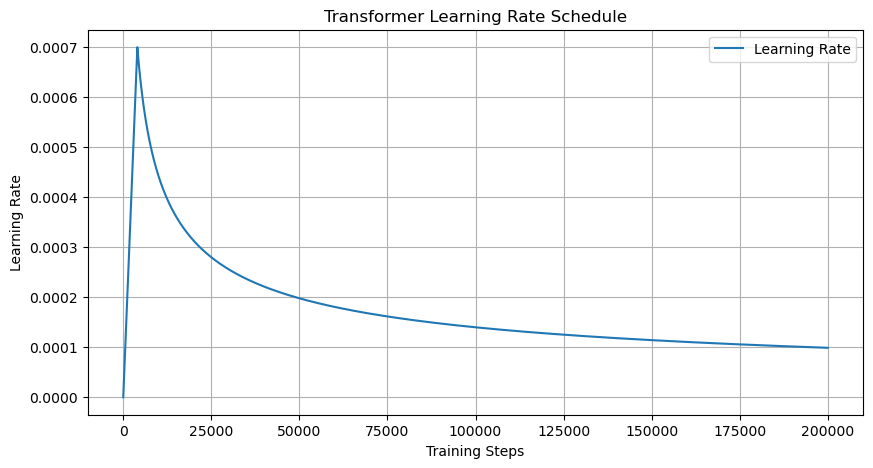

In [30]:
# 학습률 스케쥴 시각화
# 하이퍼파라미터 설정
d_model = 512
warmup_steps = 4000
total_steps = 200000  # 총 학습 스텝

# 학습률 스케줄 시각화
steps = np.arange(1, total_steps + 1)
learning_rates = [get_lr_lambda(d_model, warmup_steps)(step) for step in steps]

# 그래프 출력
plt.figure(figsize=(10, 5))
plt.plot(steps, learning_rates, label="Learning Rate")
plt.xlabel("Training Steps")
plt.ylabel("Learning Rate")
plt.title("Transformer Learning Rate Schedule")
plt.legend()
plt.grid(True)
plt.show()

In [31]:
# Optimizer 정의
# 옵티마이저의 lr은 1.0로 두고, 실제 스케일은 lambda에서 모두 제어하는 방식
optimizer = optim.Adam(model.parameters(), lr=1.0, betas=(0.9, 0.98), eps=1e-9)

# Scheduler 정의
scheduler = lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=get_lr_lambda(D_MODEL, warmup_steps=4000)
)

# 정확도: PAD 제외
def accuracy_function(logits, target, pad_id=0):
    # logits: [B, L, V], target: [B, L]
    with torch.no_grad():
        preds = logits.argmax(dim=-1)              # [B, L]
        mask = (target != pad_id)                  # [B, L]
        correct = ((preds == target) & mask).sum()
        total = mask.sum().clamp_min(1)
        return (correct.float() / total.float()).item()

# 배치 안전 언패킹: (3개 or 5개 모두 지원)
def unpack_batch(batch, device, pad_id=0):
    if len(batch) == 3:
        enc_in, dec_in, tgt = [t.to(device) for t in batch]
        # 마스크는 여기서 즉석 생성
        enc_mask = (enc_in != pad_id).long()
        dec_mask = (dec_in != pad_id).long()
    elif len(batch) == 5:
        enc_in, dec_in, tgt, enc_mask, dec_mask = [t.to(device) for t in batch]
    else:
        raise ValueError(f"Unexpected batch length: {len(batch)}")
    return enc_in, dec_in, tgt, enc_mask, dec_mask

In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)

In [33]:
import torch
from torch.nn.utils import clip_grad_norm_

pad_id = sp.pad_id() if sp.pad_id() >= 0 else 0

def train_step(model, batch, optimizer, loss_function, device, scheduler=None, grad_clip=1.0):
    model.train()

    # 배치 언패킹 (3개만 오거나 5개가 오거나 모두 처리)
    if len(batch) == 5:
        enc_in, dec_in, tgt, enc_mask, dec_mask = batch
        enc_mask = enc_mask.bool()
        dec_mask = dec_mask.bool()
    elif len(batch) == 3:
        enc_in, dec_in, tgt = batch
        enc_mask = (enc_in != pad_id).bool()
        dec_mask = (dec_in != pad_id).bool()
    else:
        raise ValueError(f"Unexpected batch length: {len(batch)}")

    enc_in = enc_in.to(device)
    dec_in = dec_in.to(device)
    tgt    = tgt.to(device)
    enc_mask = enc_mask.to(device)
    dec_mask = dec_mask.to(device)

    optimizer.zero_grad(set_to_none=True)

    # 모델 포워드 (마스크를 받는/안 받는 모델 모두 호환)
    try:
        logits = model(enc_in, dec_in, enc_mask=enc_mask, dec_mask=dec_mask)  # [B, L, V]
    except TypeError:
        logits = model(enc_in, dec_in)                                        # [B, L, V]

    # CrossEntropyLoss는 [B, V, L] 형태를 기대 → permute
    loss = loss_function(logits.permute(0, 2, 1), tgt)

    loss.backward()
    if grad_clip is not None:
        clip_grad_norm_(model.parameters(), grad_clip)
    optimizer.step()
    if scheduler is not None:
        scheduler.step()   # LambdaLR(워밍업/역제곱루트)는 보통 배치마다 step

    # 정확도 (PAD 제외)
    with torch.no_grad():
        preds = logits.argmax(dim=-1)           # [B, L]
        mask  = (tgt != pad_id)
        acc   = ((preds == tgt) & mask).sum().float() / mask.sum().clamp_min(1).float()

    return loss.item(), acc.item()

In [34]:
def train(model, dataloader, optimizer, loss_function, scheduler, num_epochs, device, log_interval=100):
    history = {"loss": [], "acc": []}
    model.to(device)

    for epoch in range(1, num_epochs + 1):
        running_loss, running_acc, steps = 0.0, 0.0, 0
        for step, batch in enumerate(dataloader, start=1):
            loss, acc = train_step(
                model=model,
                batch=batch,
                optimizer=optimizer,
                loss_function=loss_function,
                device=device,
                scheduler=scheduler,   # 배치 스텝 스케줄러일 때만 효과
            )
            running_loss += loss
            running_acc  += acc
            steps += 1

            if step % log_interval == 0:
                print(f"[Epoch {epoch:02d} | Step {step:04d}] loss={running_loss/steps:.4f} acc={running_acc/steps:.4f}")

        epoch_loss = running_loss / max(steps, 1)
        epoch_acc  = running_acc  / max(steps, 1)
        history["loss"].append(epoch_loss)
        history["acc"].append(epoch_acc)

        print(f"==> Epoch {epoch:02d} done | loss={epoch_loss:.4f} acc={epoch_acc:.4f}")

        # 에폭 단위 스케줄러를 쓰는 경우 여기에 scheduler.step() 배치
        # if scheduler is not None and use_epoch_scheduler:
        #     scheduler.step()

    return history

In [35]:
%%time

train(
    model=model,
    dataloader=dataloader,
    optimizer=optimizer,
    loss_function=loss_function,
    scheduler=scheduler,
    num_epochs=25,  # 원하는 에폭 수
    device=device
)

[Epoch 01 | Step 0100] loss=8.8191 acc=0.0524
[Epoch 01 | Step 0200] loss=8.0186 acc=0.1578
[Epoch 01 | Step 0300] loss=7.4501 acc=0.2013
==> Epoch 01 done | loss=7.1839 acc=0.2180
[Epoch 02 | Step 0100] loss=5.7870 acc=0.2961
[Epoch 02 | Step 0200] loss=5.7421 acc=0.2977
[Epoch 02 | Step 0300] loss=5.6953 acc=0.3002
==> Epoch 02 done | loss=5.6587 acc=0.3024
[Epoch 03 | Step 0100] loss=5.2911 acc=0.3121
[Epoch 03 | Step 0200] loss=5.2594 acc=0.3138
[Epoch 03 | Step 0300] loss=5.2091 acc=0.3178
==> Epoch 03 done | loss=5.1707 acc=0.3209
[Epoch 04 | Step 0100] loss=4.7815 acc=0.3370
[Epoch 04 | Step 0200] loss=4.7643 acc=0.3378
[Epoch 04 | Step 0300] loss=4.7358 acc=0.3408
==> Epoch 04 done | loss=4.7062 acc=0.3444
[Epoch 05 | Step 0100] loss=4.3226 acc=0.3670
[Epoch 05 | Step 0200] loss=4.2962 acc=0.3717
[Epoch 05 | Step 0300] loss=4.2722 acc=0.3747
==> Epoch 05 done | loss=4.2668 acc=0.3757
[Epoch 06 | Step 0100] loss=3.8165 acc=0.4132
[Epoch 06 | Step 0200] loss=3.8488 acc=0.4085
[Ep

{'loss': [7.183944091281376,
  5.658669841611707,
  5.170731918231861,
  4.706163179552233,
  4.26680639692255,
  3.852283966219103,
  3.483472036670994,
  3.173252872518591,
  2.9288664476291553,
  2.734032304222519,
  2.59133298654814,
  2.441590605233167,
  2.29137751798372,
  2.166520861032847,
  2.065031125738814,
  1.9942640836174423,
  1.9403032338297046,
  1.886926861067076,
  1.854342061764485,
  1.8176374860712,
  1.7937454677916862,
  1.774720804433565,
  1.7507817729099378,
  1.7382282083098952,
  1.721297271187241],
 'acc': [0.2179632962253448,
  0.3024277507856086,
  0.3208893630150202,
  0.34443245465691025,
  0.3756806097320608,
  0.4079031752573477,
  0.4412081811879132,
  0.47191705019087404,
  0.5012071172933321,
  0.5261905461549758,
  0.5492737179672396,
  0.5738236980663763,
  0.6004898614980079,
  0.6234926744087322,
  0.6438185334205627,
  0.6595641029847635,
  0.6712215281821586,
  0.6829048024641501,
  0.6886614116462502,
  0.6967620588637687,
  0.701094382356

In [36]:
def decoder_inference(model, sentence, tokenizer, device='cpu'):
    START_TOKEN = tokenizer.bos_id()
    END_TOKEN = tokenizer.eos_id()
    MAX_LENGTH = 40


    # 전처리
    sentence = preprocess_sentence(sentence)

    # 인코더 입력: [START] + 인코딩 + [END]
    enc_input_ids = [START_TOKEN] + tokenizer.encode(sentence) + [END_TOKEN]
    # 차원 확장: (batch_size=1, seq_len)
    enc_input = torch.tensor([enc_input_ids], dtype=torch.long, device=device)

    # 디코더 입력(dec_input)을 START_TOKEN만 포함한 상태로 시작
    dec_input = torch.tensor([[START_TOKEN]], dtype=torch.long, device=device)

    model.eval()  # 모델 평가 모드
    with torch.no_grad():
        for i in range(MAX_LENGTH):
            # 모델 forward: (enc_input, dec_input) -> (batch_size=1, seq_len, vocab_size)
            logits = model(enc_input, dec_input)

            # 마지막 타임스텝의 예측만 추출: shape (1, 1, vocab_size)
            # logits[:, -1, :] -> (1, vocab_size)
            last_step_logits = logits[:, -1, :]

            # argmax로 가장 높은 확률의 토큰 선택
            predicted_id = torch.argmax(last_step_logits, dim=-1)  # shape: (1,)

            # 종료 토큰이면 중단
            if predicted_id.item() == END_TOKEN:
                break

            # 디코더 입력(dec_input)에 예측 토큰을 이어붙임
            predicted_id = predicted_id.unsqueeze(0)  # shape (1,1)
            dec_input = torch.cat([dec_input, predicted_id], dim=1)

    # 최종 시퀀스: dec_input: (1, seq_len)에서 (seq_len,)로
    output_sequence = dec_input.squeeze(0).tolist()  # e.g. [START_TOKEN, ..., 토큰들...]

    return output_sequence

In [37]:
def sentence_generation(model, sentence, tokenizer, device='cpu'):
    # 디코더 인퍼런스 -> 예측된 토큰 시퀀스
    output_seq = decoder_inference(model, sentence, tokenizer, device=device)

    # 토크나이저로 디코딩 (패딩, START/END 토큰 등은 제외하거나 처리)
    # 여기서는 단순히 tokenizer.decode() 직접 호출
    predicted_sentence = tokenizer.decode(
        [token for token in output_seq if token < tokenizer.GetPieceSize()]
    )

    print("입력 :", sentence)
    print("출력 :", predicted_sentence)
    return predicted_sentence

In [38]:
sentence = '안녕하세요'
sentence_generation(model, sentence, sp, device)

입력 : 안녕하세요
출력 : 좋은 결과 있을 거예요 .


'좋은 결과 있을 거예요 .'

In [39]:
sentence = '날씨가 덥네요'
sentence_generation(model, sentence, sp, device)

입력 : 날씨가 덥네요
출력 : 좋은 결과 있을 거예요 .


'좋은 결과 있을 거예요 .'

In [40]:
sentence = '어떤 선택을 해야될까요?'
sentence_generation(model, sentence, sp, device)

입력 : 어떤 선택을 해야될까요?
출력 : 좋은 결과 있을 거예요 .


'좋은 결과 있을 거예요 .'

# 회고

### 디코더만 사용하는 GPT1 모델 형태로 바꾸는 방법은 알겠음

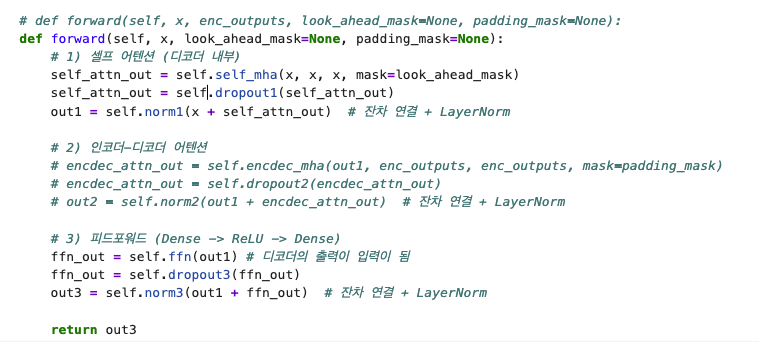


### model 요약

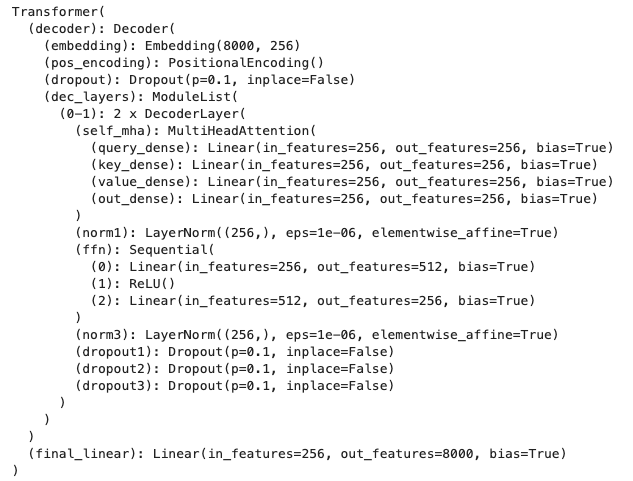

### model 학습결과

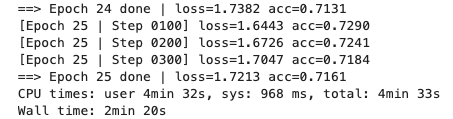

### 문제점
- 질문과 답변을 어떻게 디코더의 입력으로 사용하는 지 몰라서 항상 같은 출력을 얻는 것 같음